In [1]:
import os

os.chdir("/home/andre/SmartBinAnalysis/Deliverables")

#### Importing data

For importing Rio Maior data, we notice that its collections are together with the driver fill level information. So, we need to fetch the collections from that file and import sensor data from another

In [2]:
import extract as e

PATH_F = "Enchimentos_"
PATH_R = "Recolhas_RioMaior_Valorsul_c.csv"
PATH = "/home/andre/SmartData"
YEARS = ["2021", "2022", "2023"]

fill_df, rec_df = e.import_separate_file([PATH_F + y + ".csv" for y in YEARS], [PATH_R], path=PATH)

/home/andre/SmartBinAnalysis/Deliverables/extract.py:189: DtypeWarning: Columns (1,2,4,5,6,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  rec_df = [pd.read_csv(path + name, sep = sep_c, encoding_errors='replace') for name in src_collect]


FILL DF LINE 1: 
idcontainer                           7939
Matricula                            E3238
Tipo de contentor                      VRL
Volume                                2500
Tipo de Residuo      Mistura de embalagens
Distrito                          SANTAREM
Concelho                         RIO MAIOR
Freguesia                          Fraguas
Localidade              Ribeira de Fraguas
Latitude                         39.368838
Longitude                        -8.852379
Data de Leitura           28/12/2021 14:07
Enchimento                              65
Name: 0, dtype: object
REC DF LINE 1: 
ID contentor                         13750.0
Matricula                              E5153
Tipo de contentor                        OVO
Capacidade                            2500.0
Tipo de Residuos       Mistura de embalagens
Distrito                            SANTARÉM
Concelho                           RIO MAIOR
Freguesia                          Rio Maior
Localidade               

Again, we use the print information on the first line to give the parameters necessary (such as headers anf formats) to the pre-processing function

In [3]:
# run only once- > need to restart the kernal to work again
fill, collect, info = e.pre_process_data(
    df_fill=fill_df,
    df_collection=rec_df,
    id_header_fill="idcontainer",
    date_header_fill="Data de Leitura",
    date_format_fill="%d/%m/%Y %H:%M",
    fill_header_fill="Enchimento",
    id_header_collect="ID contentor",
    date_header_collect="Data da Recolha",
    date_format_collect="%Y-%m-%d %H:%M:%S.%f",
)

In [4]:
container_dict, ids = e.container_global_sorted_wrapper(fill, collect, info)

Container 16426.0 Collections and Measures do not intersect


As you can see, the data is real messy. Her what we need to keep in mind, is to devise the idea of acceptable noise. And that is an error bar of about 30 for each side of the prevision, because it has to do with the sensors sensibility.
 - Now, there is no marking of a zero fill reading when a collection happens. What we need to do is to is match the first reading of a sensor after each collection.
 - the noise means that the fill value of the container can drop a little after the collection
 - Collections can have a fill value up to 25 after the trash has been taken out.

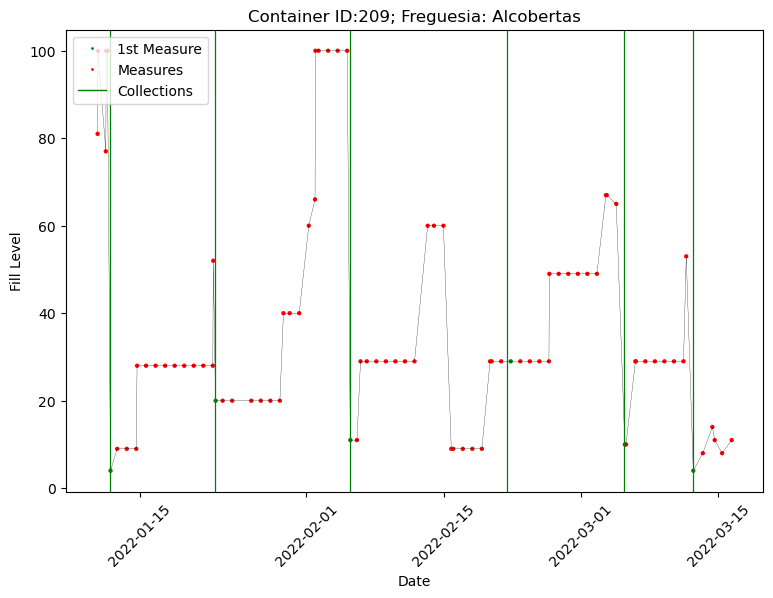

In [5]:
import random
from datetime import datetime

from Container import Container

start_date = "10-01-2022"
end_date = "17-03-2022"

# start_date = "01-09-2022"  #use this format
# end_date = datetime(year=2022, month=12, day=1) #or this

container: Container  # type annotation

# my_ids = random.sample(ids, 2)
my_ids = [209]

for id in my_ids:
    container = container_dict[id]
    container.plot_fill(start_date=start_date, end_date=end_date)

Processed 1 of 484 containers
Processed 25 of 484 containers
Processed 49 of 484 containers
Processed 73 of 484 containers
Processed 97 of 484 containers
Processed 121 of 484 containers
Processed 145 of 484 containers
Processed 169 of 484 containers
Processed 193 of 484 containers
Processed 217 of 484 containers
Processed 241 of 484 containers
Processed 265 of 484 containers
Processed 289 of 484 containers
Processed 313 of 484 containers
Processed 337 of 484 containers
Processed 361 of 484 containers
Processed 385 of 484 containers
Processed 409 of 484 containers
Processed 433 of 484 containers
Processed 457 of 484 containers
Processed 481 of 484 containers


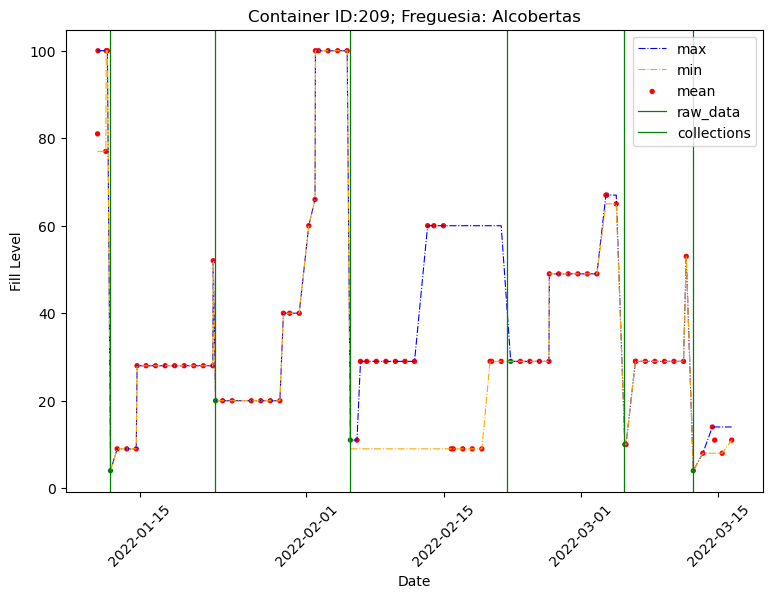

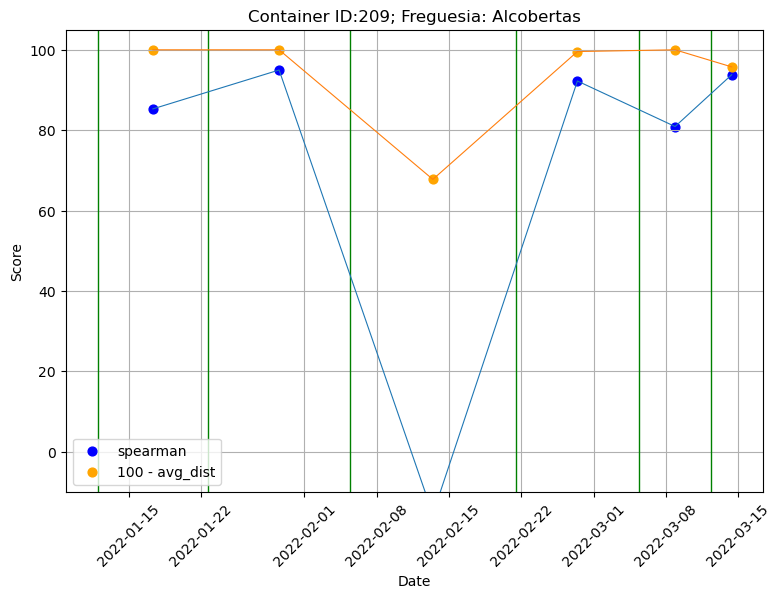

In [7]:
import transform as t

t.pre_process_container_metrics(container_dict)

container: Container
for id in my_ids:
    container = container_dict[id]
    container.plot_max_min(start_date=start_date, end_date=end_date, legend_loc="upper right")
    container.plot_collection_metrics(start_date=start_date, end_date=end_date)

In the sensor world we need two metrics. Avg_Distance is not enough. The spearman correlation is better on identifying if the sensor's reading are increasing or not, even when the collections are not well set. Therefore, we use the spearman for tagging and identifying when the sensor was inside a box or not. The parameter of 50 was experimentally determined by looking of how the histograms varied and noticing the data that was being cut. We found this to be the best compromise.

Notice that plastic and card containers have slightly different behavior; Paper is more noisy susually. If You are making a split between types of containers the value can be adjusted for one or the other

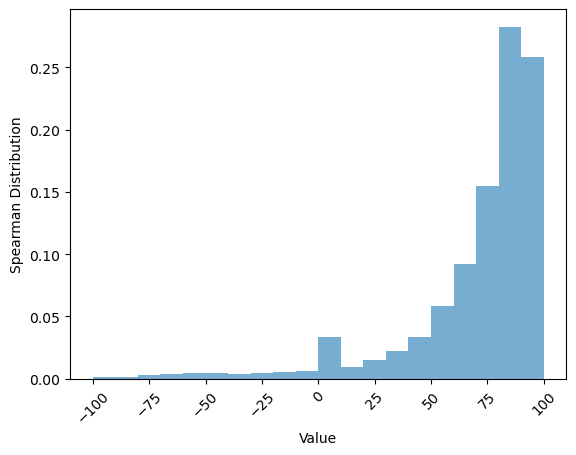

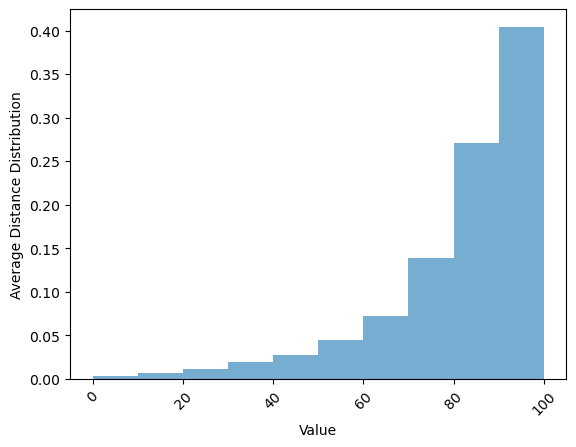

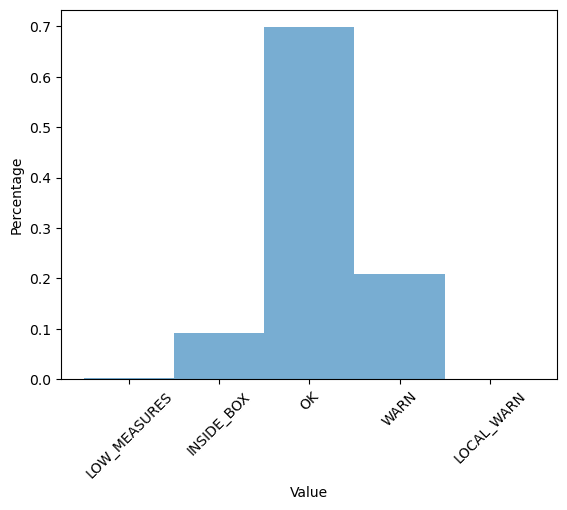

In [ ]:
import transform as t

t.view_metrics(container_dict, box_window=7, mv_thresh=50, min_days=30, use="spear")

After taking care of cleaning the dataset, we save now this information as the baseline publishable dataset along with the computed metrics. Below the cell we run a little script to aggregate and clean the info csvs to preserve just the type of residuals and shifted coordinates

In [18]:
import save_load as sl

PATH = "home/unix/MySmartData"

sl.save_id_containers(ids, path=PATH)

container: Container
for id, container in container_dict.items():
    sl.save_container_structured(id, container, path=PATH, ver="_UnCorrected_with_metrics_")

This in the end is just a sequence of commands to clean the directory for delivery putting together all the info information into one file

In [25]:
import os

import pandas as pd

# Directory containing the CSV files
directory_path = "/home/unix/MySmartData"

# List to hold DataFrames
dataframes = []

# Loop over files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".csv") and "info" in filename:
        # Read each CSV file into a DataFrame
        df = pd.read_csv(os.path.join(directory_path, filename))
        dataframes.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dataframes, ignore_index=True, axis=0)

# print(combined_df)
# Drop duplicate rows based on the 'ID' column and set 'ID' as the index
combined_df = combined_df.drop_duplicates(subset="ID").set_index("ID")

# Select specific columns
final_df = combined_df.loc[:, ["Capacidade", "Tipo de Residuos", "Latitude", "Longitude"]]

final_df.rename(
    columns={
        "Capacidade": "Capacity",
        "Tipo de Residuos": "WasteType",
        "Latitude": "Latitude",
        "Longitude": "Longitude",
    },
    errors="raise",
    inplace=True,
)


# Save the final DataFrame to a new CSV file
final_df.to_csv("/home/unix/Deliver_data/INFO.csv")